In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
#from IPython.core.pylabtools import figsize
from tensorflow import keras
from keras import optimizers
from keras import Sequential
from keras import layers
from keras import utils, callbacks
from keras.models import Model
from keras.applications import *
from keras.layers import Flatten, Dense, Dropout, BatchNormalization, Conv2D, Input, MaxPool2D, Permute, GlobalAveragePooling2D, MaxPooling2D
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.metrics import SparseCategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, accuracy_score
from time import perf_counter
from keras.backend import clear_session

In [ ]:
%pip install split-folders

In [53]:
#tuning
split_ratio = (0.75,0.15,0.10)
img_target_size = (64,64)
data_batch_size = 105
#cnn_layers = 4
#output_classes = 26 #A-Z and nothing,space
#learning_rate = 0.0001
#epochs = 3

In [4]:
#split dataset into train, val, test
import splitfolders
splitfolders.ratio("./grassknot/", output="./pt_data/",
    seed=42, ratio=split_ratio, group_prefix=None, move=False)

Copying files: 78026 files [01:58, 657.02 files/s]


In [28]:
from zipfile import ZipFile
with ZipFile("../massey.zip","r") as zipObj:
    zipObj.extractall()

In [29]:
#split dataset into train, val, test
import splitfolders
splitfolders.ratio("../massey/", output="../tfl_data/",
    seed=42, ratio=(0.70,0.20,0.10), group_prefix=None, move=False)

Copying files: 1815 files [00:07, 235.93 files/s]


In [54]:
gen_aug = ImageDataGenerator(rescale=1./255, horizontal_flip=True, rotation_range=15) 
gen = ImageDataGenerator(rescale=1./255) 

train = gen_aug.flow_from_directory("../tfl_data/train",
                                target_size=img_target_size,
                                batch_size=data_batch_size, 
                                shuffle=True)

val = gen.flow_from_directory("../tfl_data/val",
                              target_size=img_target_size,
                              batch_size=data_batch_size, shuffle=False)

test = gen.flow_from_directory("../tfl_data/test", 
                               target_size=img_target_size, 
                               class_mode=None, shuffle=False)

Found 1270 images belonging to 26 classes.
Found 363 images belonging to 26 classes.
Found 182 images belonging to 26 classes.


In [11]:
#get a fraction of training data for checking which model trains and fits the best
#split dataset into train, val, test
import splitfolders
splitfolders.ratio("./data/train/", output="./pt_data/",
    seed=42, ratio=(0.1,0.05,0.85), group_prefix=None, move=False)

Copying files: 58500 files [01:22, 712.09 files/s]


In [12]:
pt_train = gen_aug.flow_from_directory("./pt_data/train",
                                target_size=img_target_size,
                                batch_size=data_batch_size, 
                                shuffle=True)

pt_val = gen.flow_from_directory("./pt_data/val",
                              target_size=img_target_size,
                              batch_size=data_batch_size, shuffle=False)

Found 5850 images belonging to 26 classes.
Found 2912 images belonging to 26 classes.


In [19]:
models = {
    "InceptionResNetV2": {"model":tf.keras.applications.InceptionResNetV2, "perf":0},
    "InceptionV3": {"model":tf.keras.applications.InceptionV3, "perf":0},
    "ResNet101": {"model":tf.keras.applications.ResNet101, "perf":0},
    "ResNet101V2": {"model":tf.keras.applications.ResNet101V2, "perf":0},
    "ResNet152": {"model":tf.keras.applications.ResNet152, "perf":0},
    "ResNet152V2": {"model":tf.keras.applications.ResNet152V2, "perf":0},
    "ResNet50": {"model":tf.keras.applications.ResNet50, "perf":0},
    "ResNet50V2": {"model":tf.keras.applications.ResNet50V2, "perf":0},
    "VGG16": {"model":tf.keras.applications.VGG16, "perf":0},
    "VGG19": {"model":tf.keras.applications.VGG19, "perf":0},
    "Xception": {"model":tf.keras.applications.Xception, "perf":0}
}

In [45]:
best_model = keras.models.load_model("./results/best_model/saved_best_model")
best_model_weights = best_model.weights

In [58]:
def get_model(model):
# Load the pretained model
    kwargs =    {'input_shape':(64, 64, 3),
                'include_top':False,
                 'weights': best_model_weights,
                'pooling':'max'}
    
    model = model(**kwargs)
    model.trainable = False
    
    inputs = model.input

    x = Dense(128, activation='elu')(model.output)
    x = Dense(128, activation='elu')(x)

    outputs = Dense(26, activation='softmax')(x)

    new_model = Model(inputs=inputs, outputs=outputs)

    new_model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return new_model

In [20]:
# def get_model(model):
# # Load the pretained model
#     kwargs =    {'input_shape':(128, 128, 3),
#                 'include_top':False,
#                  'weights':'imagenet',
#                 'pooling':'max'}
    
#     pretrained_model = model(**kwargs)
#     pretrained_model.trainable = False
    
#     inputs = pretrained_model.input

#     x = Dense(128, activation='relu')(pretrained_model.output)
#     x = Dense(128, activation='relu')(x)

#     outputs = Dense(26, activation='softmax')(x)

#     model = Model(inputs=inputs, outputs=outputs)

#     model.compile(
#         optimizer='adam',
#         loss='categorical_crossentropy',
#         metrics=['accuracy']
#     )
    
#     return model

In [59]:
# Fit the models
    
    # Get the model
m = get_model(best_model)
start = perf_counter()
    # Fit the model
history = m.fit(train,validation_data=val,epochs=10,verbose=0)
    
# Sav the duration and the val_accuracy
duration = perf_counter() - start
duration = round(duration,2)
print(f"Trained in {duration} sec")
val_acc = history.history['val_accuracy']

ValueError: The first argument to `Layer.call` must always be passed.

In [30]:
models_result = []

for name, v in models.items():
    models_result.append([ name, models[name]['val_acc'][4],models[name]['perf']])
    
df_results = pd.DataFrame(models_result, 
                          columns = ['model','val_accuracy','Training time (sec)'])
df_results.sort_values(by='val_accuracy', ascending=False, inplace=True)
df_results.reset_index(inplace=True,drop=True)
df_results

,model,val_accuracy,Training time (sec)
0,ResNet50V2,0.8595,105.35
1,ResNet101V2,0.8372,128.45
2,ResNet152V2,0.8170,146.02
3,VGG16,0.7998,113.19
4,Xception,0.7672,123.33
5,InceptionResNetV2,0.7064,165.10
6,InceptionV3,0.6861,110.20
7,VGG19,0.5968,118.80
8,ResNet101,0.2586,131.35
9,ResNet152,0.2517,148.34


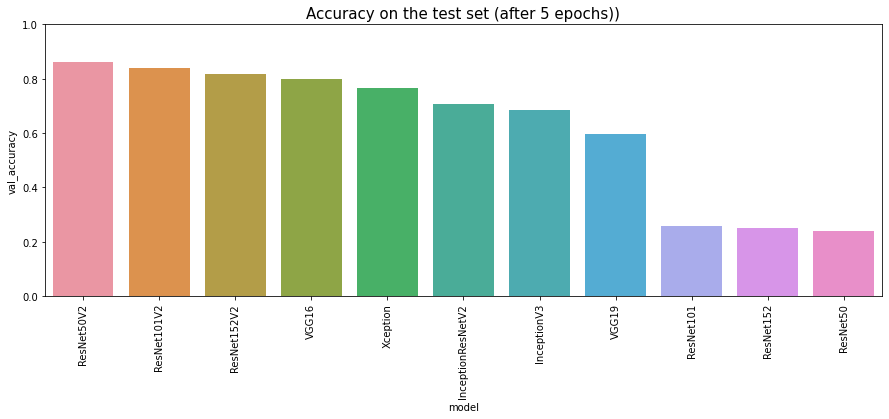

In [34]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results)
plt.title('Accuracy on the test set (after 5 epochs))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)

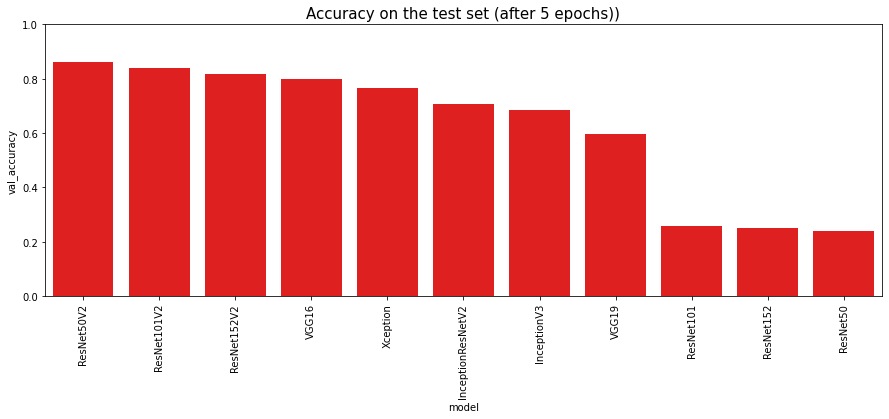

In [42]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'model', y = 'val_accuracy', data = df_results,color="red")
plt.title('Accuracy on the test set (after 5 epochs))', fontsize = 15)
plt.ylim(0,1)
plt.xticks(rotation=90)
plt.show()

In [69]:
#Train data on the best architecture - in this case - ResNet5OV2
best_pretrained_model = df_results.iloc[0]

# Create a new model
pretrained_model = get_model( eval("tf.keras.applications."+ best_pretrained_model[0]) )

clear_session()
# Train the model
history = pretrained_model.fit(train,
                    validation_data=val,
                    epochs=15,
                    callbacks=[
                        tf.keras.callbacks.EarlyStopping(
                            monitor='val_loss',
                            patience=3,
                            restore_best_weights=True)]
                    )

Epoch 1/15
915/915 [==============================] - 203s 213ms/step - loss: 0.8663 - accuracy: 0.7287 - val_loss: 0.3557 - val_accuracy: 0.8803
Epoch 2/15
915/915 [==============================] - 186s 203ms/step - loss: 0.3547 - accuracy: 0.8817 - val_loss: 0.2682 - val_accuracy: 0.9077
Epoch 3/15
915/915 [==============================] - 196s 214ms/step - loss: 0.2708 - accuracy: 0.9080 - val_loss: 0.2263 - val_accuracy: 0.9215
Epoch 4/15
915/915 [==============================] - 197s 216ms/step - loss: 0.2336 - accuracy: 0.9225 - val_loss: 0.1744 - val_accuracy: 0.9418
Epoch 5/15
915/915 [==============================] - 192s 210ms/step - loss: 0.2047 - accuracy: 0.9312 - val_loss: 0.2074 - val_accuracy: 0.9309
Epoch 6/15
915/915 [==============================] - 182s 199ms/step - loss: 0.1962 - accuracy: 0.9348 - val_loss: 0.2083 - val_accuracy: 0.9336
Epoch 7/15
915/915 [==============================] - 182s 199ms/step - loss: 0.1767 - accuracy: 0.9410 - val_loss: 0.1465 -

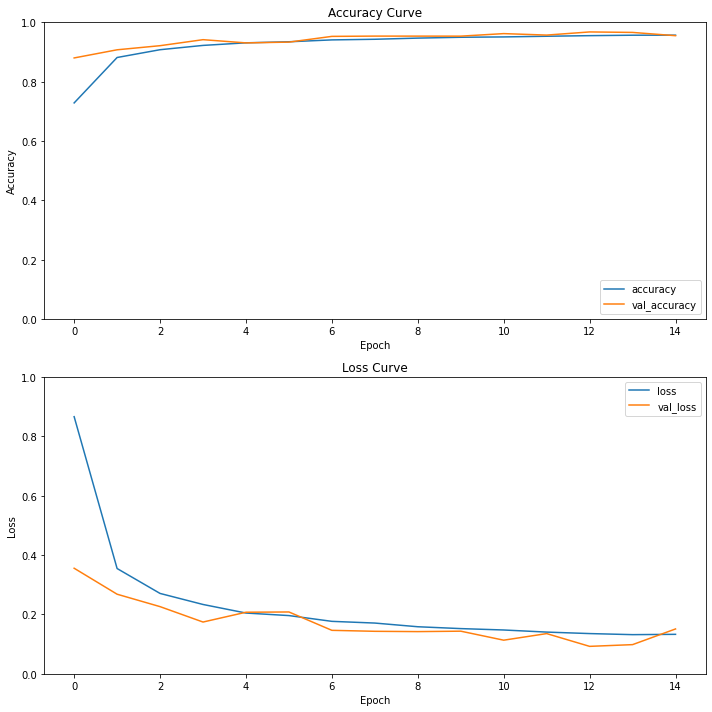

In [70]:
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Accuracy Curve')

plt.subplot(2,1,2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label = 'val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([0, 1])
plt.legend(loc='upper right')
plt.title('Loss Curve')
  
plt.rcParams["figure.figsize"] = (10,10)
plt.tight_layout()
  #plt.rcParams['savefig.orientation'] = 'landscape'
  #plt.savefig(fig_path)
plt.show()

In [1]:
pred = pretrained_model.predict(test, batch_size=(test.samples//test.batch_size+1))
pred_vals = np.argmax(pred, axis=1)
score = accuracy_score(test.classes,pred_vals)
print(score)

NameError: name 'pretrained_model' is not defined